# Mod 3 Final Project

Jeremy Owens, Georgina Sampson

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup
import time
import copy
%matplotlib inline

In [2]:
crime_data = pd.read_csv('denver_data/crime_short.csv')
dispensary_data = pd.read_csv('denver_data/marijuana_active_business_licenses.csv')

In [3]:
print(len(crime_data))
crime_data.head()

450000


,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [4]:
crime_data.columns = [x.lower() for x in crime_data.columns]

In [5]:
crime_data = crime_data[crime_data.is_crime == 1]

In [6]:
crime_data['year'] = crime_data.reported_date.apply(lambda date: int(date.split()[0][-4:]))

In [7]:
offense_type_ids = list(crime_data.groupby('offense_type_id').count().index)

In [8]:
violent_list = [off for off in offense_type_ids if 'assault' in off] + \
                    [off for off in offense_type_ids if 'homicide' in off] + \
                    [off for off in offense_type_ids if 'robbery' in off] + \
                    [off for off in offense_type_ids if 'sex-aslt' in off] + \
                    ['agg-aslt-police-weapon', 'aslt-agg-police-gun']
violent_list.pop(violent_list.index('traf-vehicular-assault'))

drug_list = [off for off in offense_type_ids if 'drug' in off]

In [9]:
def gen_offense_type(offense):
    if offense in violent_list:
        return 'violent'
    elif offense in drug_list:
        return 'drug'
    else:
        return 'other'

In [10]:
crime_data['gen_offense_type'] = crime_data.offense_type_id.apply(lambda offense: gen_offense_type(offense))

In [11]:
crime_data_short = crime_data.drop(['offense_code', 'offense_id', 'offense_code_extension', 'offense_type_id', 
                                    'offense_category_id', 'first_occurrence_date', 'last_occurrence_date', 
                                    'incident_address', 'geo_x', 'geo_y', 'geo_lon', 'geo_lat', 'district_id', 
                                    'precinct_id', 'is_crime', 'is_traffic', 'reported_date'], 
                                    axis=1)
crime_data_short.sample(10)

,incident_id,neighborhood_id,year,gen_offense_type
253857,2018469670,capitol-hill,2018,other
24198,2018366142,union-station,2018,other
368276,2019113816,east-colfax,2019,other
348612,2017459540,montbello,2017,other
29482,201964874,gateway-green-valley-ranch,2019,other
32898,20193628,regis,2019,other
38041,2018862052,sun-valley,2018,other
271237,2015336637,civic-center,2015,other
324352,20175002276,civic-center,2017,other
417842,20186005319,globeville,2018,other


In [12]:
crime_data_grouped = crime_data_short.groupby(['neighborhood_id', 'year', 'gen_offense_type']).count()
crime_data_grouped = crime_data_grouped.reset_index()
crime_data_grouped

,neighborhood_id,year,gen_offense_type,incident_id
0,athmar-park,2014,drug,77
1,athmar-park,2014,other,957
2,athmar-park,2014,violent,91
3,athmar-park,2015,drug,82
4,athmar-park,2015,other,923
5,athmar-park,2015,violent,111
6,athmar-park,2016,drug,72
7,athmar-park,2016,other,998
8,athmar-park,2016,violent,97
9,athmar-park,2017,drug,64


In [13]:
dispensary_data.columns = [x.lower().replace(' ', '_') for x in dispensary_data.columns]
dispensary_data = dispensary_data[['business_file_number', 'license_type', 'facility_zip_code']]
dispensary_data

,business_file_number,license_type,facility_zip_code
0,2016-BFN-0007402,Retail Marijuana Store,80204.0
1,2018-BFN-0000285,Retail Marij Opt. Prem. Cultiv,80216.0
2,2018-BFN-0000461,Retail Marijuana Store,80239.0
3,2014-BFN-0004431,Med Marijuana Opt Prem Cultiv,80216.0
4,2014-BFN-0004811,Retail Marijuana Store,80216.0
5,2013-BFN-1065013,Med Marijuana Opt Prem Cultiv,80216.0
6,2013-BFN-1066526,Med Marijuana Inf Prod Manuf,80216.0
7,2013-BFN-1066097,Med Marijuana Inf Prod Manuf,NaN
8,2013-BFN-1069615,Retail Marijuana Store,80210.0
9,2013-BFN-1069055,Retail Marijuana Store,80202.0


In [14]:
dispensary_data.dropna(inplace=True)
dispensary_data['zip_code'] = dispensary_data.facility_zip_code.astype('int64')
dispensary_data.drop('facility_zip_code', inplace=True, axis=1)

In [15]:
stores_data = dispensary_data[dispensary_data.license_type.isin(['Retail Marijuana Store', 
                                                                 'Medical Marijuana Center'])]
print(len(stores_data))
stores_data.head(10)

345


,business_file_number,license_type,zip_code
0,2016-BFN-0007402,Retail Marijuana Store,80204
2,2018-BFN-0000461,Retail Marijuana Store,80239
4,2014-BFN-0004811,Retail Marijuana Store,80216
8,2013-BFN-1069615,Retail Marijuana Store,80210
9,2013-BFN-1069055,Retail Marijuana Store,80202
11,2016-BFN-0004809,Retail Marijuana Store,80223
12,2015-BFN-0002256,Medical Marijuana Center,80211
19,2018-BFN-0007446,Retail Marijuana Store,80205
20,2010-BFN-1045700,Medical Marijuana Center,80209
21,2010-BFN-1048389,Medical Marijuana Center,80216


In [16]:
store_count = stores_data.groupby('zip_code')['business_file_number'].count()
store_count
#counting number of stores in each zipcode

zip_code
80123     2
80127     2
80202    13
80203    18
80204    25
80205    22
80206     5
80207     6
80209     8
80210    35
80211    20
80212     6
80214     2
80216    45
80218     6
80219    21
80220    15
80222     9
80223    39
80224    10
80231     4
80232     4
80236     2
80237     2
80239    20
80247     2
80249     2
Name: business_file_number, dtype: int64

In [17]:
html_page = requests.get('http://www.city-data.com/zipmaps/Denver-Colorado.html')
soup = BeautifulSoup(html_page.content, 'html.parser')

In [18]:
zip_code_list = []
zip_codes = soup.find(class_="zip-codes").findAll('a', recursive=False)
for tag in zip_codes:
    zip_code_list.append(int(tag.text))
zip_code_list[:5]

[80012, 80014, 80110, 80111, 80123]

In [19]:
zip_neighbor_dict = {}
for zip_code in zip_code_list:
    html_page = requests.get('http://www.city-data.com/zips/{}.html'.format(zip_code))
    soup = BeautifulSoup(html_page.content, 'html.parser')
    neighborhoods = []
    for a in soup.find_all('a'):
        if 'neighborhood' in a.text:
            if a.text.split()[-1] == 'neighborhood':
                if len(a.text.split()) < 6:
                    if 'Central Business District' in a.text:
                        neighborhood = 'cbd'
                    elif '(' in a.text:
                        neighborhood = '-'.join(a.text[:(a.text.index('(') - 1)].split()).lower()
                    else:
                        neighborhood = '-'.join(a.text.split()[:-1]).lower()
                    neighborhoods.append(neighborhood)
    zip_neighbor_dict.update({zip_code: neighborhoods})
    time.sleep(0.5)
    
zip_neighbor_dict

{80012: ['aurora-district', 'city-center'],
 80014: ['cherry-creek-district', 'kennedy'],
 80110: ['college-view',
  'fort-logan',
  'harvey-park-south',
  'overland',
  'south-platte',
  'southwest',
  'university',
  'wellshire'],
 80111: ['kennedy'],
 80123: ['fort-logan', 'marston', 'southwest'],
 80202: ['cbd',
  'central-platte-valley',
  'cbd',
  'five-points',
  'highland',
  'lower-downtown',
  'north-capitol-hill',
  'union-station'],
 80203: ['alamo-placita',
  'capitol-hill',
  'civic-center',
  'five-points',
  'golden-triangle',
  'north-capitol-hill',
  'speer',
  'uptown'],
 80204: ['auraria',
  'baker',
  'barnum',
  'barnum-west',
  'cbd',
  'civic-center',
  'colfax',
  'cbd',
  'golden-triangle',
  'lincoln-park',
  'lower-downtown',
  'sheridan-boulevard',
  'sloan-lake',
  'southwest',
  'sun-valley',
  'union-station',
  'valverde',
  'villa-park'],
 80205: ['ballpark',
  'city-park',
  'city-park-west',
  'clayton',
  'cole',
  'curtis-park',
  'five-points',
  

In [20]:
crime_neighborhoods = list(crime_data_short.neighborhood_id.unique())
sorted(crime_neighborhoods)

['athmar-park',
 'auraria',
 'baker',
 'barnum',
 'barnum-west',
 'bear-valley',
 'belcaro',
 'berkeley',
 'capitol-hill',
 'cbd',
 'chaffee-park',
 'cheesman-park',
 'cherry-creek',
 'city-park',
 'city-park-west',
 'civic-center',
 'clayton',
 'cole',
 'college-view-south-platte',
 'congress-park',
 'cory-merrill',
 'country-club',
 'dia',
 'east-colfax',
 'elyria-swansea',
 'five-points',
 'fort-logan',
 'gateway-green-valley-ranch',
 'globeville',
 'goldsmith',
 'hale',
 'hampden',
 'hampden-south',
 'harvey-park',
 'harvey-park-south',
 'highland',
 'hilltop',
 'indian-creek',
 'jefferson-park',
 'kennedy',
 'lincoln-park',
 'lowry-field',
 'mar-lee',
 'marston',
 'montbello',
 'montclair',
 'north-capitol-hill',
 'north-park-hill',
 'northeast-park-hill',
 'overland',
 'platt-park',
 'regis',
 'rosedale',
 'ruby-hill',
 'skyland',
 'sloan-lake',
 'south-park-hill',
 'southmoor-park',
 'speer',
 'stapleton',
 'sun-valley',
 'sunnyside',
 'union-station',
 'university',
 'universit

In [21]:
zip_neighbor_dict_mod = copy.deepcopy(zip_neighbor_dict)

In [22]:
for key, values in zip_neighbor_dict_mod.items():
    counter = 0
    list_len = len(values)
    if list_len == 0:
        continue
    else:
        while counter < list_len:
            if values[counter] not in crime_neighborhoods:
                del values[counter]
                list_len -= 1
            else:
                counter += 1
for key, values in zip_neighbor_dict_mod.items():
    values = list(set(values))
    zip_neighbor_dict_mod.update({key: values})
zip_neighbor_dict_mod

{80012: [],
 80014: ['kennedy'],
 80110: ['university',
  'overland',
  'harvey-park-south',
  'wellshire',
  'fort-logan'],
 80111: ['kennedy'],
 80123: ['fort-logan', 'marston'],
 80202: ['five-points',
  'union-station',
  'north-capitol-hill',
  'highland',
  'cbd'],
 80203: ['civic-center',
  'north-capitol-hill',
  'capitol-hill',
  'five-points',
  'speer'],
 80204: ['union-station',
  'barnum',
  'lincoln-park',
  'civic-center',
  'sloan-lake',
  'barnum-west',
  'baker',
  'sun-valley',
  'auraria',
  'villa-park',
  'cbd',
  'valverde'],
 80205: ['city-park-west',
  'clayton',
  'whittier',
  'north-capitol-hill',
  'cole',
  'city-park',
  'five-points',
  'skyland'],
 80206: ['city-park-west',
  'congress-park',
  'cherry-creek',
  'city-park',
  'cheesman-park',
  'country-club'],
 80207: ['stapleton',
  'northeast-park-hill',
  'south-park-hill',
  'north-park-hill'],
 80209: ['belcaro',
  'washington-park',
  'washington-park-west',
  'cherry-creek',
  'speer',
  'count

In [23]:
neighborhoods_df = pd.DataFrame.from_dict(zip_neighbor_dict_mod, orient='index')
neighborhoods_df.dropna(how='all', inplace=True)
neighborhoods_df = neighborhoods_df.reset_index()
neighborhoods_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11
0,80014,kennedy,None,None,None,None,None,None,None,None,None,None,None
1,80110,university,overland,harvey-park-south,wellshire,fort-logan,None,None,None,None,None,None,None
2,80111,kennedy,None,None,None,None,None,None,None,None,None,None,None
3,80123,fort-logan,marston,None,None,None,None,None,None,None,None,None,None
4,80202,five-points,union-station,north-capitol-hill,highland,cbd,None,None,None,None,None,None,None


In [24]:
def calc_crime(zip_code, year, crime_type):
    sum_of_crime = 0
    if crime_type == 'violent':
        for neighborhood in zip_neighbor_dict_mod[zip_code]:
            sum_of_crime += crime_data_grouped[(crime_data_grouped.neighborhood_id == neighborhood) & 
                                               (crime_data_grouped.year == year) &
                                               (crime_data_grouped.gen_offense_type == 'violent')]['incident_id'].sum()
    elif crime_type == 'drug':
        for neighborhood in zip_neighbor_dict_mod[zip_code]:
            sum_of_crime += crime_data_grouped[(crime_data_grouped.neighborhood_id == neighborhood) & 
                                               (crime_data_grouped.year == year) &
                                               (crime_data_grouped.gen_offense_type == 'drug')]['incident_id'].sum()
    elif crime_type == 'all':
        for neighborhood in zip_neighbor_dict_mod[zip_code]:
            sum_of_crime += crime_data_grouped[(crime_data_grouped.neighborhood_id == neighborhood) & 
                                               (crime_data_grouped.year == year)]['incident_id'].sum()
            
    return int(round(sum_of_crime / len(zip_neighbor_dict_mod[zip_code]), 0))


In [25]:
neighborhoods_df['2014_all_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2014, 'all'))
neighborhoods_df['2014_violent_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2014, 'violent'))
neighborhoods_df['2014_drug_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2014, 'drug'))

neighborhoods_df['2017_all_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2017, 'all'))
neighborhoods_df['2017_violent_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2017, 'violent'))
neighborhoods_df['2017_drug_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2017, 'drug'))


In [26]:
neighborhoods_df = neighborhoods_df.drop(range(12), axis=1)
neighborhoods_df.rename({'index': 'zip_code'}, axis=1, inplace=True)
neighborhoods_df.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime
0,80014,250,41,3,335,51,9
1,80110,389,45,19,388,38,20
2,80111,250,41,3,335,51,9
3,80123,296,30,4,417,53,4
4,80202,2012,246,205,2078,275,181


In [27]:
final_df = neighborhoods_df.join(store_count, on='zip_code')
final_df.fillna(0, inplace=True)
final_df.rename({'business_file_number': 'dispensary_count'}, axis=1, inplace=True)
final_df = final_df.astype({'dispensary_count': 'int64'})
final_df.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count
0,80014,250,41,3,335,51,9,0
1,80110,389,45,19,388,38,20,0
2,80111,250,41,3,335,51,9,0
3,80123,296,30,4,417,53,4,2
4,80202,2012,246,205,2078,275,181,13


## Scraping for median income and population per zip-code

In [28]:
html_page = requests.get('http://www.city-data.com/zipmaps/Denver-Colorado.html') #Make a get request to retrieve the page
soup = BeautifulSoup(html_page.content, 'html.parser') #Pass the page contents to beautiful soup for parsing

In [29]:
def medianIncomePerYear(year, html):
    for zipStatistics in html.findAll('div', class_="data-block"):
        # <strong>Zip code 80014 statistics:</strong>
        strong = zipStatistics.find('strong').text
        zipCode = int(re.match(r"(Zip code )(\d{5})( statistics:)", strong).groups()[1])
        median_household_income = 0
        for bold_tag in zipStatistics.findAll('b'):
            if f"Estimated median household income in {year}:" in bold_tag.text:
                income_string = bold_tag.nextSibling
                income_string = income_string.strip()
                income_string = re.sub("\$", "", income_string)
                income_string = re.sub(",","", income_string)
                median_household_income = int(income_string)
        yield {zipCode: median_household_income}
medianIncomePerYear2016 = [zipCode for zipCode in medianIncomePerYear(2016, soup)]
medianIncomePerYear2016_fulldict = {}
for zip_code_income in medianIncomePerYear2016:
    for key, val in zip_code_income.items():
        if val == 0:
            continue
        else:
            medianIncomePerYear2016_fulldict.update({key: val})
medianIncomePerYear2016_fulldict

{80012: 47637,
 80014: 54779,
 80110: 50448,
 80111: 101311,
 80123: 77226,
 80202: 73743,
 80203: 49252,
 80204: 36586,
 80205: 60235,
 80206: 67196,
 80207: 67419,
 80209: 89207,
 80210: 80986,
 80211: 66879,
 80212: 67427,
 80214: 39190,
 80216: 45290,
 80218: 55713,
 80219: 43188,
 80220: 71270,
 80221: 52867,
 80222: 52772,
 80223: 45186,
 80224: 53003,
 80226: 57716,
 80227: 64022,
 80230: 80495,
 80231: 53219,
 80232: 65087,
 80235: 57765,
 80236: 53593,
 80237: 69327,
 80239: 52513,
 80246: 47818,
 80249: 73623}

In [30]:
def Population(year, html):
    for zipStatistics in html.findAll('div', class_="data-block"):
        # <strong>Zip code 80014 statistics:</strong>
        strong = zipStatistics.find('strong').text
        zipCode = int(re.match(r"(Zip code )(\d{5})( statistics:)", strong).groups()[1])
        pop = 0
        for bold_tag in zipStatistics.findAll('b'):
            if f"Estimated zip code population in {year}:" in bold_tag.text:
                income_string = bold_tag.nextSibling
                income_string = income_string.strip()
                income_string = re.sub("\$", "", income_string)
                income_string = re.sub(",","", income_string)
                pop = int(income_string)
        yield {zipCode: pop}
pop2016 = [zipCode for zipCode in Population(2016, soup)]
pop2016_fulldict = {}
for zip_code_pop in pop2016:
    for key, val in zip_code_pop.items():
        if val == 0:
            continue
        else:
            pop2016_fulldict.update({key: val})
pop2016_fulldict

{80012: 51510,
 80014: 39054,
 80110: 22106,
 80111: 32382,
 80123: 46458,
 80202: 12824,
 80203: 20809,
 80204: 32769,
 80205: 33012,
 80206: 23852,
 80207: 25706,
 80209: 25608,
 80210: 36503,
 80211: 33735,
 80212: 19700,
 80214: 25614,
 80216: 12640,
 80218: 19055,
 80219: 68307,
 80220: 36227,
 80221: 41064,
 80222: 21577,
 80223: 19956,
 80224: 19338,
 80226: 32775,
 80227: 35484,
 80230: 8612,
 80231: 36425,
 80232: 22719,
 80235: 8015,
 80236: 18749,
 80237: 20158,
 80239: 46496,
 80246: 13474,
 80249: 29440}

In [31]:
final_df_income = final_df.join(pd.DataFrame.from_dict(medianIncomePerYear2016_fulldict, orient='index'), 
                                on='zip_code')
final_df_income = final_df_income.rename({0: 'median_income'}, axis=1)

final_df_income_pop = final_df_income.join(pd.DataFrame.from_dict(pop2016_fulldict, orient='index'), 
                                on='zip_code')
final_df_income_pop = final_df_income_pop.rename({0: 'population'}, axis=1)
final_df_income_pop.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population
0,80014,250,41,3,335,51,9,0,54779,39054
1,80110,389,45,19,388,38,20,0,50448,22106
2,80111,250,41,3,335,51,9,0,101311,32382
3,80123,296,30,4,417,53,4,2,77226,46458
4,80202,2012,246,205,2078,275,181,13,73743,12824


In [32]:
def econ_status(income):
    if income <= final_df_income_pop.median_income.quantile([0.25]).sum():
        return 'low'
    elif income >= final_df_income_pop.median_income.quantile([0.75]).sum():
        return 'high'
    else:
        return 'middle'

In [33]:
final_df_income_pop['store_per_1Kpeople'] = round(final_df_income_pop.dispensary_count / 
                                                  (final_df_income_pop.population / 1000), 4)
final_df_income_pop['neighborhood_econ_status'] = final_df_income_pop.median_income.apply(lambda income: econ_status(income))
final_df_income_pop['2017_log'] = np.log(final_df_income_pop["2017_all_crime"])
final_df_income_pop

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population,store_per_1Kpeople,neighborhood_econ_status,2017_log
0,80014,250,41,3,335,51,9,0,54779,39054,0.0000,middle,5.814131
1,80110,389,45,19,388,38,20,0,50448,22106,0.0000,low,5.961005
2,80111,250,41,3,335,51,9,0,101311,32382,0.0000,high,5.814131
3,80123,296,30,4,417,53,4,2,77226,46458,0.0430,high,6.033086
4,80202,2012,246,205,2078,275,181,13,73743,12824,1.0137,high,7.639161
5,80203,1721,232,156,2085,273,250,18,49252,20809,0.8650,low,7.642524
6,80204,1102,130,92,1086,138,81,25,36586,32769,0.7629,low,6.990257
7,80205,930,122,80,1024,141,91,22,60235,33012,0.6664,middle,6.931472
8,80206,550,53,17,555,57,15,5,67196,23852,0.2096,middle,6.318968
9,80207,993,88,40,1036,97,46,6,67419,25706,0.2334,middle,6.943122


In [34]:
conn = sqlite3.connect("database.sqlite")
c = conn.cursor()

In [35]:
final_df_income_pop.set_index('zip_code').to_sql('zip_code_statistics', conn, if_exists='replace')

In [36]:
 pd.read_sql_query('''SELECT * FROM zip_code_statistics''', conn)
final_df_income_pop['2017_log'] = np.log(final_df_income_pop["2017_all_crime"])

In [175]:
Mean_Crime_Before_Legal = np.log(final_df_income_pop.loc[:,"2014_all_crime"].mean())
Mean_Crime_After_Legal = np.log(final_df_income_pop.loc[:,"2017_all_crime"].mean())
print(Mean_Crime_Before_Legal)
Mean_Crime_After_Legal

6.650368262611925


6.714254222423225

In [176]:
n =len(final_df_income_pop)
n

29

c.close()
conn.close()

In [177]:
#The sample contains 25 observations, having a mean of 109.5456 and a standard deviation (sigma) =  13.338774643871902 ,
#with 24 degrees of freedom. The difference between sample and population means is: 9.545599999999993

In [178]:
## Import the packages
import numpy as np
from scipy import stats 
import math

# For visualizing distributions - optional 
import seaborn as sns
import matplotlib.pyplot as plt

# Population mean (μ)
mu = (Mean_Crime_Before_Legal)

# Sample mean (x̄) using NumPy mean()
x_bar= (Mean_Crime_After_Legal)


# Sample Stadrad Deviation (sigma) using Numpy
sigma = np.std(final_df_income_pop.loc[:,"2017_all_crime"],ddof=1)
var= sigma**2 

# Sample size (n)
n = len(final_df_income_pop)

# Degrees of Freedom
df = n-1

# Difference in sample mean 
diff = x_bar - mu


# Print the findings
print ('The sample contains', n, 'observations, having a mean of', x_bar, "and a standard deviation (sigma) = ", sigma, 
       ", with", df, 'degrees of freedom. The difference between sample and population means is:', diff)
print(var)
# The sample contains 29 observations, having a mean of 824.0689655172414 
# and a standard deviation (sigma) =  551.67725 , 
# with 24 degrees of freedom. 
# The difference between sample and population means is: 9.54   

The sample contains 29 observations, having a mean of 6.714254222423225 and a standard deviation (sigma) =  561.4422073702233 , with 28 degrees of freedom. The difference between sample and population means is: 0.06388595981129974
315217.3522167488


In [179]:
# sns.set(color_codes=True)
# sns.set(rc={'figure.figsize':(12,10)})
# sns.distplot(np.log(final_df_income_pop["2017_all_crime"])) #blue
# sns.distplot(np.log(final_df_income_pop.loc[:,"2014_all_crime"]))


In [180]:
#The two-sample t-test is used to determine 
#if two population means are equal.
#A common application is to test if a new process or treatment is superior to a current process or treatment.


In [228]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [275]:
#logs of all crime in 2017(control), then 2014(experimental)
control = np.array(final_df_income_pop.loc[:,"2014_all_crime"])

experimental = np.array(final_df_income_pop.loc[:,"2017_all_crime"])
print((control))
print((experimental))

[ 250  389  250  296 2012 1721 1102  930  550  993  427  308  663  518
 1472 1329  913  723  360  686  920  673  570  420  340  432  403 2174
  595]
[ 335  388  335  417 2078 2085 1086 1024  555 1036  420  301  656  492
 1655 1486  824  790  330  743  770  699  648  496  436  436  554 2256
  567]


In [276]:
# Mean_Crime_After_Legal - (Mean_Crime_Before_Legal)

In [277]:
#It is always a good idea to draw the probability distributions for samples to visually inspect the differences present between mean and standard deviation. Plot both samples' distributions and inspect 
#the overlap using seaborn to get an idea how different the samples might be from one another.

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

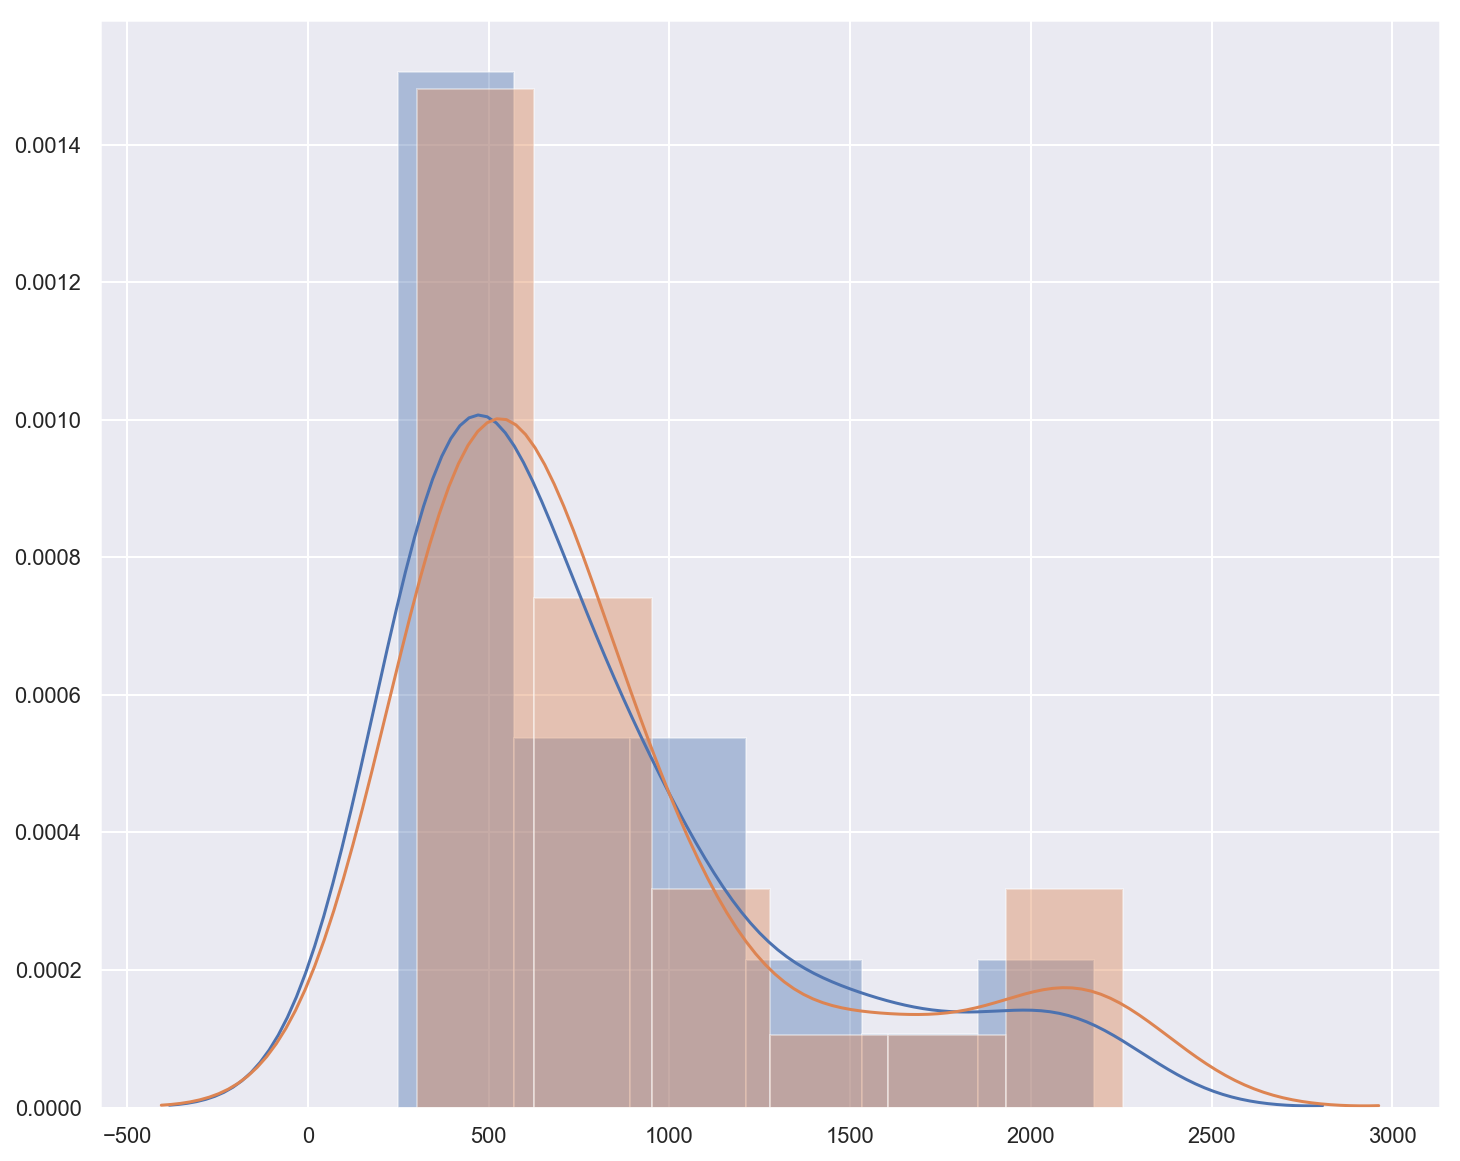

In [292]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
#sns.distplot(np.log(final_df_income_pop["2017_all_crime"])) # Blue distribution
sns.distplot(control)
sns.distplot(experimental)
# Green distribution



In [279]:
# Difference between distribution means
#pop mean
c_mean= control.mean()
#sample mean
e_mean= experimental.mean()
#diffeence between means
experimental.mean() - control.mean()
e_mean-c_mean  

51.0

In [334]:
from scipy import stats
import numpy as np
import seaborn as sns

alpha=.05
    # Sample Standard Deviation (sigma) using Numpy
sigma = np.std(experimental)

# Degrees of freedom
df = (n - 1)

print(experimental.var())
control.var()
effect_size= 51/sigma
effect_size

304347.7883472057


0.09244535638355302

power = 0.0755

We got this power from by inserting our knows values into https://www.anzmtg.org/stats/PowerCalculator/PowerTtest

This represents why our graph is off:
Because we have a type two error!

Type 2 error:

type II error is the non-rejection of a false null hypothesis (also known as a "false negative" finding or conclusion)

Ttest_relResult(statistic=2.956620083214908, pvalue=0.006251998095096172)

#A type II error is a statistical term used within the context of hypothesis testing that describes the error that occurs when one fails to reject a null hypothesis that is actually false. In other words, it produces a false positive. The error rejects the alternative hypothesis, even though it does not occur due to chance.

***The power of a statistical test is defined as the probability of rejecting the null hypothesis, given that it is indeed false. As with any probability, the power of a statistical test therefore ranges from 0 to 1, with 1 being a perfect test that guarantees rejecting the null hypothesis when it is indeed false.... our power when we calculated it was 0.0755.. not even .1!***

***because we have an alpha of .05 and a pvalue of .006, we reject our null hypothesis, 
the null hypothesis (there was no significant change in crime rate from 2014-2017)

Simply put, power is the probability of not making a Type II error

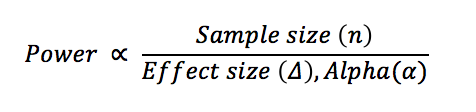

statsmodels.stats.power.TTestPower¶


In [350]:
statsmodels.stats.power.TTestPower.power(control, experimental)

TypeError: power() missing 2 required positional arguments: 'nobs' and 'alpha'

In [281]:
pooledVar=(df* experimental.var() + df*  control.var()) /((n + n)-2)
pooledVar

283734.40903686086

In [288]:
def twosample_tstatistic(experimental, control):
    exp_mean, ctrl_mean = np.mean(experimental), np.mean(control)
    pool_var=pooledVar
    num = exp_mean - ctrl_mean
    denom = np.sqrt(pool_var * ((1/29)+(1/29)))
    return (num / denom)

t_stat = twosample_tstatistic(experimental, control)
t_stat

0.36458447715872894

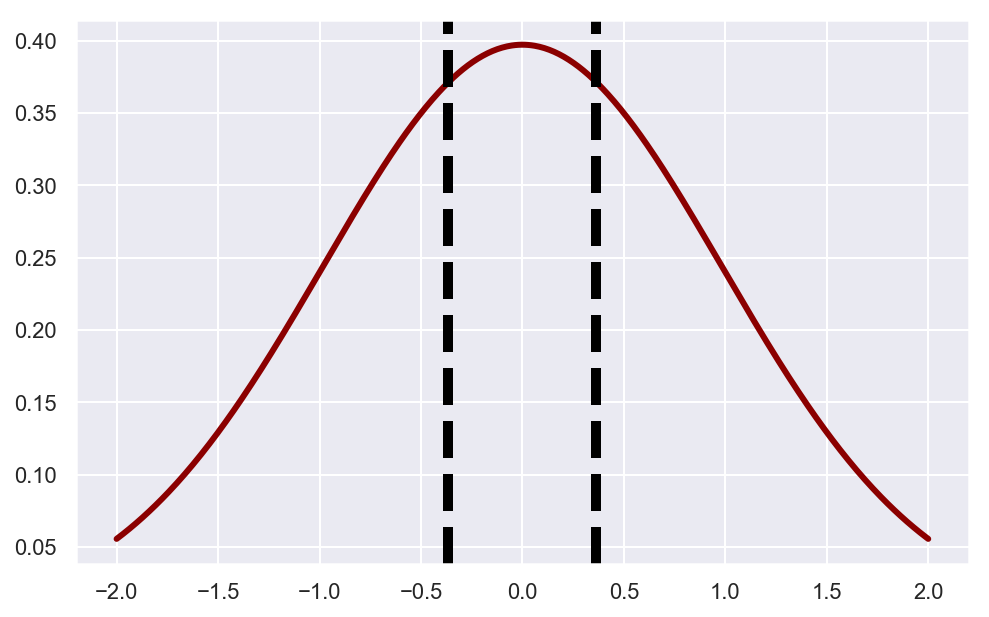

In [283]:
# Visualize p_value

def visualize_t(t_stat, n_control, n_experimental):
    
    """
    Visualize the critical t values on a t distribution
    
    
    """

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-2, 2, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2))
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control,n_experimental)

In [284]:
stats.t.cdf(experimental, control)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [287]:
stats.ttest_rel(control, experimental)

Ttest_relResult(statistic=-2.8974227153512264, pvalue=0.007228332192368434)

In [ ]:
Ttest_relResult(statistic=2.956620083214908, pvalue=0.006251998095096172)

***because we have an alpha of .05 and a pvalue of .006, we reject our null hypothesis, 
the null hypothesis there was no change in crime rate from 2014-2017 


#which we said that crime rate has not 

In [274]:
t_crit = np.round(stats.t.ppf(1 - 0.025, df),3)
t_crit

2.048

In [273]:
t_crit = np.round(stats.t.pdf(1 - 0.25, df),3)
t_crit

0.296

In [150]:
# def sample_variance(experimental):
#     return np.sum((experimental - e_mean) **2)/ (len(experimental) -1)
    
# sample_variance(experimental)

In [ ]:
#What is the probability that you would observe this data GIVEN a specified mean difference in blood pressure?

#You obviously don't know the true mean difference in blood pressure resulting from administration the drug.
#The whole point of conducting the experiment is to evaluate the drug.
#Instead you must assume that the true mean difference is zero: the null hypothesis $H_{0}$ is assumed to be true:



In [ ]:
#Now, create some functions to calculate the t-statistic. The first function to create is one that calculates the variance for a single sample.

def sample_variance(sample):
    sample_mean = np.mean(sample)
    return np.sum((sample - sample_mean) **2)/ (len(sample) -1)
sample_variance(control)

In [ ]:
#Using sample_variance, you can now write another function pooled_variance to calculate $S_{p}^{2}$

def pooled_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = sample_variance(sample1), sample_variance(sample2)
    return ((n_1-1) * var_1 + (n_2-1)* var_2)/((n_1 + n_2)-2)

In [ ]:
def twosample_tstatistic(experimental, control):
    exp_mean, ctrl_mean = np.mean(experimental), np.mean(control)
    pool_var = pooled_variance(experimental, control)
    n_e, n_c = len(experimental), len(control)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(pool_var * ((1/n_e)+(1/n_c)))
    return num / denom

t_stat = twosample_tstatistic(experimental, control)
t_stat


In [ ]:
def visualize_t(t_stat, n_control, n_experimental):
    
    """
    Visualize the critical t values on a t distribution
    
    Parameters
    -----------
    t-stat: float
    n_control: int
    n_experiment: int
    
    Returns
    ----------
    None
    
    """

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)

In [ ]:
## Calculate p_value
# Lower tail comulative density function returns area under the lower tail curve
lower_tail = stats.t.cdf(-1.89, (50+50-2), 0, 1)
# Upper tail comulative density function returns area under upper tail curve
upper_tail = 1. - stats.t.cdf(1.89, (50+50-2), 0, 1)

p_value = lower_tail+upper_tail
print(p_value)

In [301]:
'''
Calculates the T-test for the means of *two independent* samples of scores.

This is a two-sided test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.
'''

stats.ttest_ind(experimental, control)

Ttest_indResult(statistic=0.35824339383580645, pvalue=0.721508109827735)

In [339]:
nobs=29

In [343]:
alpha=.05

In [347]:
effect_size= 51/sigma
effect_size

0.09244535638355302

In [348]:
df

28

In [346]:
statsmodels.stats.power.TTestPower.power(effect_size, nobs, df, alpha, alternative='two-sided')




1.0

In [310]:
import statsmodels.api as sm

In [335]:
.power(effect_size, nobs, alpha, alternative='two-sided')
TTestPower.power(effect_size, nobs, alpha, df=None, alternative='two-sided')

SyntaxError: invalid syntax (<ipython-input-335-92507192b9d4>, line 1)

# Working Zone

In [ ]:
print(len(crime_data))
crime_data.isna().sum()

In [ ]:
print(len(crime_data))
crime_data.sample(10)

In [ ]:
html_page = requests.get('http://www.city-data.com/zips/{}.html'.format(80202))
soup = BeautifulSoup(html_page.content, 'html.parser')
neighborhoods = []
for a in soup.find_all('a'):
    if 'neighborhood' in a.text:
        if a.text.split()[-1] == 'neighborhood':
            if len(a.text.split()) < 6:
                if 'Central Business District' in a.text:
                    neighborhood = 'cbd'
                elif '(' in a.text:
                    neighborhood = '-'.join(a.text[:(a.text.index('(') - 1)].split()).lower()
                else:
                    neighborhood = '-'.join(a.text.split()[:-1]).lower()
                neighborhoods.append(neighborhood)
neighborhoods

In [ ]:
neighborhoods_to_analyze = {}
for key, val in initial_neighborhood_counts.items():
    if val > 1:
        like_neighborhoods = []
        for key2, val2 in zip_neighbor_dict_mod.items():
             if key in val2:
                    like_neighborhoods.append(key2)
        neighborhoods_to_analyze.update({key: like_neighborhoods})
neighborhoods_to_analyze

In [ ]:
violent_data = crime_data[crime_data['gen_offense_type'] == 'violent']
drug_data = crime_data[crime_data['gen_offense_type'] == 'drug']

In [ ]:
neighborhoods_to_analyze = {}
for key, val in initial_neighborhood_counts.items():
    if val > 1:
        like_neighborhoods = []
        for key2, val2 in zip_neighbor_dict_mod.items():
             if key in val2:
                    like_neighborhoods.append(key2)
        neighborhoods_to_analyze.update({key: like_neighborhoods})
neighborhoods_to_analyze

In [ ]:
offense_data.head(10)

In [ ]:
offense_data.groupby('OFFENSE_CATEGORY_ID')['OFFENSE_CODE'].count()

In [ ]:
print(len(dispensary_data))
dispensary_data.sample(10)

In [ ]:
dispensary_data.groupby('Trade Name').count()

In [ ]:
dispensary_data[dispensary_data['Trade Name'] == '1136 YUMA']